In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler


In [3]:
Retail_Data_Response = pd.read_csv("/content/Retail_Data_Response.csv")
days_since_last_txn = pd.read_excel("/content/days_since_last_txn (1).xlsx")
mth_day_counts = pd.read_excel("/content/mth_day_counts (3) (1).xlsx")
mth_rolling_features = pd.read_excel("/content/mth_rolling_features (1).xlsx")


In [36]:
Retail_Data_Response.set_index("customer_id")

,response
customer_id,
CS1112,0
CS1113,0
CS1114,1
CS1115,1
CS1116,1
...,...
CS8996,0
CS8997,0
CS8998,0


In [9]:
days_since_last_txn.drop(columns=["Unnamed: 0"],inplace=True)
days_since_last_txn.set_index(["customer_id","ME_DT"])
mth_day_counts.drop(columns=["Unnamed: 0"],inplace=True)
mth_day_counts.set_index(["customer_id","ME_DT"])
mth_rolling_features.drop(columns=["Unnamed: 0"],inplace=True)
mth_rolling_features.set_index(["CLNT_NO","ME_DT"])

mth_txn_amt_sum  ...  txn_cnt_max_12M
CLNT_NO ME_DT                        ...                 
CS1112  2011-05-31                0  ...              NaN
        2011-06-30               56  ...              NaN
        2011-07-31                0  ...              NaN
        2011-08-31               96  ...              NaN
        2011-09-30                0  ...              NaN
...                             ...  ...              ...
CS9000  2014-11-30                0  ...              1.0
        2014-12-31                0  ...              1.0
        2015-01-31                0  ...              1.0
        2015-02-28                0  ...              1.0
        2015-03-31               34  ...              1.0

[323783 rows x 20 columns]

In [29]:
mth_rolling_features_joint=mth_rolling_features.merge(mth_day_counts,how="left",left_index=True,right_index=True)
days_since_last_txn_joint=days_since_last_txn.merge(mth_rolling_features_joint,how="left",left_index=True,right_index=True)


In [30]:
days_since_last_txn_joint.drop(columns=["CLNT_NO","ME_DT_x","customer_id_y","ME_DT_y"],inplace=True)

In [31]:
days_since_last_txn_joint.fillna(0,inplace=True)

In [32]:
days_since_last_txn_joint.set_index("customer_id_x",inplace=True)


In [34]:
days_since_last_txn_joint

,ME_DT,days_since_last_txn,mth_txn_amt_sum,mth_txn_cnt,amt_sum_3M,amt_mean_3M,amt_max_3M,txn_cnt_sum_3M,txn_cnt_mean_3M,txn_cnt_max_3M,amt_sum_6M,amt_mean_6M,amt_max_6M,txn_cnt_sum_6M,txn_cnt_mean_6M,txn_cnt_max_6M,amt_sum_12M,amt_mean_12M,amt_max_12M,txn_cnt_sum_12M,txn_cnt_mean_12M,txn_cnt_max_12M,cnt_Friday,cnt_Monday,cnt_Saturday,cnt_Sunday,cnt_Thursday,cnt_Tuesday,cnt_Wednesday
customer_id_x,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CS1112,2011-05-31,0.0,0,0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0,0,0,0,0,0,0
CS1112,2011-06-30,15.0,56,1,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0,0,0,0,0,0,1
CS1112,2011-07-31,46.0,0,0,56.0,18.666667,56.0,1.0,0.333333,1.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0,0,0,0,0,0,0
CS1112,2011-08-31,12.0,96,1,152.0,50.666667,96.0,2.0,0.666667,1.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,1,0,0,0,0,0,0
CS1112,2011-09-30,42.0,0,0,96.0,32.000000,96.0,1.0,0.333333,1.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CS9000,2014-11-30,98.0,0,0,0.0,0.000000,0.0,0.0,0.000000,0.0,61.0,10.166667,35.0,2.0,0.333333,1.0,97.0,8.083333,35.0,4.0,0.333333,1.0,0,0,0,0,0,0,0
CS9000,2014-12-31,129.0,0,0,0.0,0.000000,0.0,0.0,0.000000,0.0,61.0,10.166667,35.0,2.0,0.333333,1.0,97.0,8.083333,35.0,4.0,0.333333,1.0,0,0,0,0,0,0,0
CS9000,2015-01-31,160.0,0,0,0.0,0.000000,0.0,0.0,0.000000,0.0,35.0,5.833333,35.0,1.0,0.166667,1.0,81.0,6.750000,35.0,3.0,0.250000,1.0,0,0,0,0,0,0,0


In [37]:
monly_features = days_since_last_txn_joint.merge(Retail_Data_Response.set_index("customer_id"),how="left",left_index=True,right_index=True)

In [43]:
monly_features.set_index(['ME_DT'], append=True,inplace=True)

In [48]:
monly_features.index = [i[0]+str(i[1]) for i in monly_features.index]

In [50]:
monly_features.dropna(inplace=True)

In [51]:
x_monthly = monly_features.drop(["response"],axis=1)
y_monthly = monly_features["response"]

# 1.  Split the train/test sets with 9:1 ratio This split should give you approximately 291k/32ksamples in train/test set, respectively.

In [52]:
x_train_monthly, x_test_monthly, y_train_monthly, y_test_monthly = train_test_split(x_monthly, y_monthly, test_size=1/9, random_state=1147)

# 2.  Initialize  and  create  a  for  loop  in  which  you  take  N  samples  (e.g.   50),  build  a  treemodel with the N samples and evaluate the test set AUC. Repeat the sampling process10 times and append the test set AUC. The following table shows the desired output:

In [53]:
decisiontree = DecisionTreeClassifier(max_depth=3,class_weight="balanced")
auc_test = []
for i in range(10):
  input = x_train_monthly.sample(n=50,random_state=i)
  output = y_train_monthly.sample(n=50,random_state=i)
  decisiontree.fit(input,output)
  scores_test = decisiontree.predict_proba(x_test_monthly)[:,1]
  fpr_test, tpr_test, _ = roc_curve(y_test_monthly, scores_test)
  auc_test.append(auc(fpr_test, tpr_test))


In [54]:
performance = pd.DataFrame({"Test AUC": auc_test,"Sample #": np.arange(1,11)})
performance.columns = [["n=50","n=50"],["Test AUC", "Sample #"]]
display(performance)
aucmean = np.mean(performance["n=50"]["Test AUC"].values)
aucstd = np.std(performance["n=50"]["Test AUC"].values)
print("mean: %2f, std: %2f" % (aucmean,aucstd))

n=50         
   Test AUC Sample #
0  0.522108        1
1  0.490213        2
2  0.516371        3
3  0.520011        4
4  0.515910        5
5  0.548726        6
6  0.494914        7
7  0.561195        8
8  0.528951        9
9  0.515105       10

mean: 0.521351, std: 0.020393


# 3.  Repeat the procedure you performed in the previous step for different sample size N(e.g.  100, 500, 1000, 2000, 5000, 10000)

In [150]:
sizes = [100,200,500,1000,2000,4000,5000,10000,15000,20000,29000]
decisiontree = DecisionTreeClassifier(max_depth=4,class_weight="balanced")
auc_test_set = []
for size in sizes:
  auc_test = []
  for i in range(10):
    input = x_train_monthly.sample(n=size,random_state=i)
    output = y_train_monthly.sample(n=size,random_state=i)
    decisiontree.fit(input,output)
    scores_test = decisiontree.predict_proba(x_test_monthly)[:,1]
    fpr_test, tpr_test, _ = roc_curve(y_test_monthly, scores_test)
    auc_test.append(auc(fpr_test, tpr_test))
  auc_test_set.append(auc_test)
auc_test_set

[[0.5104246937272955,
  0.5053612904311426,
  0.5541794108803098,
  0.5126008965545026,
  0.5371881043431039,
  0.5347541937653407,
  0.475616401128259,
  0.524981284278919,
  0.5256174017450922,
  0.5046482041894658],
 [0.5452263428494042,
  0.546192723024774,
  0.5306703074376337,
  0.5295619343187467,
  0.571796828715357,
  0.5412969765145174,
  0.5343018002885107,
  0.5331958297421018,
  0.5084099546913964,
  0.5456681022128229],
 [0.5416494038648891,
  0.5281649931338757,
  0.5073037975815943,
  0.5433138132510081,
  0.5167016509431493,
  0.5579282976087642,
  0.5185294079558148,
  0.5478536332096892,
  0.4914728561957261,
  0.5422089302326716],
 [0.5693118225194957,
  0.5619992519080953,
  0.5556234843487555,
  0.553141722535805,
  0.547289242542704,
  0.5640256989344983,
  0.5442057864847853,
  0.5384292241417289,
  0.5499039421491125,
  0.5598408727104269],
 [0.585516691549218,
  0.6003085612912757,
  0.5699678931680858,
  0.5739125076476203,
  0.5779398561665403,
  0.577303647

In [151]:
performances = pd.DataFrame(auc_test_set)
performances.columns = [("Trial "+str(i)) for i in range(1,11)]
performances.index = ["n = "+str(size) for size in sizes]
performances["mean"] = performances.agg("mean",axis=1)
performances["std"] = performances.agg("std",axis=1)
display(performances)


,Trial 1,Trial 2,Trial 3,Trial 4,Trial 5,Trial 6,Trial 7,Trial 8,Trial 9,Trial 10,mean,std
n = 100,0.510425,0.505361,0.554179,0.512601,0.537188,0.534754,0.475616,0.524981,0.525617,0.504648,0.518537,0.020695
n = 200,0.545226,0.546193,0.530670,0.529562,0.571797,0.541297,0.534302,0.533196,0.508410,0.545668,0.538632,0.015377
n = 500,0.541649,0.528165,0.507304,0.543314,0.516702,0.557928,0.518529,0.547854,0.491473,0.542209,0.529513,0.019671
n = 1000,0.569312,0.561999,0.555623,0.553142,0.547289,0.564026,0.544206,0.538429,0.549904,0.559841,0.554377,0.009139
n = 2000,0.585517,0.600309,0.569968,0.573913,0.577940,0.577304,0.584931,0.566262,0.595542,0.582040,0.581372,0.010159
n = 4000,0.615743,0.619268,0.610910,0.591544,0.584886,0.612483,0.613264,0.600304,0.609015,0.585452,0.604287,0.012162
n = 5000,0.618131,0.620921,0.597593,0.616415,0.607934,0.611335,0.610308,0.610468,0.590873,0.595761,0.607974,0.009562
n = 10000,0.625545,0.620413,0.609037,0.620156,0.616545,0.612281,0.622746,0.626572,0.612259,0.606934,0.617249,0.006545
n = 15000,0.627648,0.630417,0.617795,0.633863,0.619713,0.624590,0.632982,0.624964,0.626487,0.629553,0.626801,0.004991
n = 20000,0.636263,0.632774,0.627921,0.635005,0.632116,0.635583,0.628191,0.634730,0.622462,0.630370,0.631542,0.004133


# 4.  Build a table that contains the values of:Sample size NTest AUC meanTest AUC standard deviation

In [152]:
display(performances)

,Trial 1,Trial 2,Trial 3,Trial 4,Trial 5,Trial 6,Trial 7,Trial 8,Trial 9,Trial 10,mean,std
n = 100,0.510425,0.505361,0.554179,0.512601,0.537188,0.534754,0.475616,0.524981,0.525617,0.504648,0.518537,0.020695
n = 200,0.545226,0.546193,0.530670,0.529562,0.571797,0.541297,0.534302,0.533196,0.508410,0.545668,0.538632,0.015377
n = 500,0.541649,0.528165,0.507304,0.543314,0.516702,0.557928,0.518529,0.547854,0.491473,0.542209,0.529513,0.019671
n = 1000,0.569312,0.561999,0.555623,0.553142,0.547289,0.564026,0.544206,0.538429,0.549904,0.559841,0.554377,0.009139
n = 2000,0.585517,0.600309,0.569968,0.573913,0.577940,0.577304,0.584931,0.566262,0.595542,0.582040,0.581372,0.010159
n = 4000,0.615743,0.619268,0.610910,0.591544,0.584886,0.612483,0.613264,0.600304,0.609015,0.585452,0.604287,0.012162
n = 5000,0.618131,0.620921,0.597593,0.616415,0.607934,0.611335,0.610308,0.610468,0.590873,0.595761,0.607974,0.009562
n = 10000,0.625545,0.620413,0.609037,0.620156,0.616545,0.612281,0.622746,0.626572,0.612259,0.606934,0.617249,0.006545
n = 15000,0.627648,0.630417,0.617795,0.633863,0.619713,0.624590,0.632982,0.624964,0.626487,0.629553,0.626801,0.004991
n = 20000,0.636263,0.632774,0.627921,0.635005,0.632116,0.635583,0.628191,0.634730,0.622462,0.630370,0.631542,0.004133


# 5.  Using the matplotlib function errorbar,  plot the model performance captured in thetest AUC mean and standard deviation as a function of the sample size.  From thisplot, can you estimate what is the minimum number of samples needed to model thebehaviour adequately?

Text(0.5, 1.0, 'Average test_AUC for training size gradient')

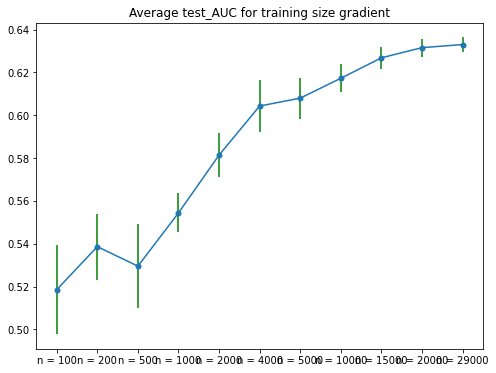

In [153]:
plt.rcParams["figure.figsize"] = (8,6)
plt.errorbar(x=performances.index,y=performances["mean"],yerr=performances["std"],marker='o',ecolor="g",markersize=5)
plt.title("Average test_AUC for training size gradient")


From the plot, we can find that we can find the average test_AUC did not show an significant increase after training size reached to 20k. Therefore, 20k samples would be the minimum training size to model the behaviour adequately. However, as displayed by the plot, larger training size than 20k would reduce the standard deviation of the average test_Auc to provide more stable model performance.  

On ther other hand, it's not wise to treat the record of a client for each month as an individual sample because the labels of the dataset are giving for each client regardless of which month or year. Therefore, if we separate one sample of a single client into n samples of that client for each month, those n samples would be biased because the labels are not given to tell if the client defaulted in that monthly but default records over the whole observation. This could be reason of low model performance.

# Treat the record of each month or year as a feature for each client 

In [127]:
month_features_regardless_month = pd.read_excel("/content/1 (1).xlsx")

In [137]:
month_features_regardless_month.set_index("customer_id",inplace=True)

In [138]:
x = month_features_regardless_month.drop(["response"],axis=1)
y = month_features_regardless_month["response"]

In [139]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1/9, random_state=1147)

In [143]:
sizes = [100,200,500,1000,2000,4000,5000,6000]
decisiontree = DecisionTreeClassifier(max_depth=3,class_weight="balanced")
auc_test_set = []
for size in sizes:
  auc_test = []
  for i in range(10):
    input = x_train.sample(n=size,random_state=i)
    
    output = y_train.sample(n=size,random_state=i)
    
    decisiontree.fit(input,output)
    scores_test = decisiontree.predict_proba(x_test)[:,1]
    fpr_test, tpr_test, _ = roc_curve(y_test, scores_test)
    auc_test.append(auc(fpr_test, tpr_test))
  auc_test_set.append(auc_test)
auc_test_set

[[0.5053745348008551,
  0.5470148071898012,
  0.5006631562277298,
  0.5564672578984876,
  0.569670995328213,
  0.5500534484123841,
  0.5902189405336923,
  0.596870298519281,
  0.5219039512233747,
  0.5711754691582864],
 [0.570304457993507,
  0.6164680497268192,
  0.5942968564415234,
  0.516371050756196,
  0.6092921054715338,
  0.5877939662681132,
  0.5706211893261541,
  0.5477373505424024,
  0.5474206192097554,
  0.6257423390608916],
 [0.6818433763560061,
  0.6738657059149576,
  0.672895716208726,
  0.6676498535117588,
  0.6813682793570355,
  0.6549014173727136,
  0.6760432338269063,
  0.6661651753899753,
  0.6681546440731648,
  0.6632651041254256],
 [0.6741131522685881,
  0.7171787156544461,
  0.6661948689524111,
  0.7242952727848602,
  0.692127246812891,
  0.6648289650803705,
  0.7064197481985905,
  0.6931665214981393,
  0.7523160978699819,
  0.6555744714545886],
 [0.736984321799034,
  0.7090525774012195,
  0.7652723889460764,
  0.7632928181170322,
  0.728491962942434,
  0.6518231847

In [144]:
performances = pd.DataFrame(auc_test_set)
performances.columns = [("Trial "+str(i)) for i in range(1,11)]
performances.index = ["n = "+str(size) for size in sizes]
performances["mean"] = performances.agg("mean",axis=1)
performances["std"] = performances.agg("std",axis=1)
display(performances)

,Trial 1,Trial 2,Trial 3,Trial 4,Trial 5,Trial 6,Trial 7,Trial 8,Trial 9,Trial 10,mean,std
n = 100,0.505375,0.547015,0.500663,0.556467,0.569671,0.550053,0.590219,0.596870,0.521904,0.571175,0.550941,0.031475
n = 200,0.570304,0.616468,0.594297,0.516371,0.609292,0.587794,0.570621,0.547737,0.547421,0.625742,0.578605,0.032953
n = 500,0.681843,0.673866,0.672896,0.667650,0.681368,0.654901,0.676043,0.666165,0.668155,0.663265,0.670615,0.007890
n = 1000,0.674113,0.717179,0.666195,0.724295,0.692127,0.664829,0.706420,0.693167,0.752316,0.655574,0.694622,0.029166
n = 2000,0.736984,0.709053,0.765272,0.763293,0.728492,0.651823,0.750247,0.742230,0.722385,0.719168,0.728895,0.031107
n = 4000,0.743309,0.764966,0.762778,0.765203,0.753761,0.719534,0.751109,0.785296,0.766460,0.732194,0.754461,0.018004
n = 5000,0.756493,0.782831,0.753098,0.738281,0.750297,0.757898,0.795085,0.766520,0.755196,0.771944,0.762764,0.015856
n = 6000,0.772132,0.772132,0.758354,0.751019,0.772666,0.752029,0.769816,0.761204,0.772132,0.770043,0.765153,0.008258


Text(0.5, 1.0, 'Average test_AUC for training size gradient')

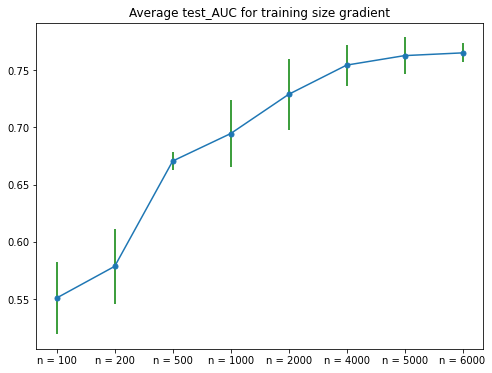

In [145]:
plt.errorbar(x=performances.index,y=performances["mean"],yerr=performances["std"],marker='o',ecolor="g",markersize=5)
plt.title("Average test_AUC for training size gradient")

Here we can see when we treat the record of each month or year as a feature for each client, we are able to get more accurate prediction